In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

In [2]:
n_BHs = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_BHs = new_powerlaw_mass_distribution(n_BHs, 
                                         10.0|units.MSun, 
                                         100.0|units.MSun, 
                                         alpha_IMF)

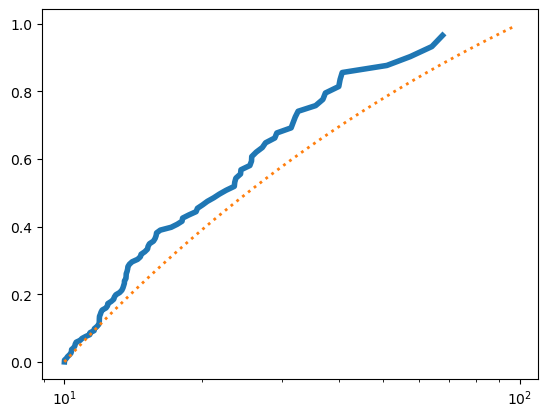

In [3]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = numpy.array([0])
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-")
    x = 10**numpy.arange(1.0, 2.0, 1./len(m))
    y = x**(alpha_IMF+2)
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":")
    pyplot.semilogx()
    pyplot.show()
plot_cdf(m_BHs)

In [4]:
r_cluster = 3.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_BHs.sum(), r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_BHs, W0, convert_nbody=converter)
bodies.mass = m_BHs.in_(units.MSun)
bodies.scale_to_standard(converter)

In [5]:
from amuse.lab import Particles
SMBH = Particles(1)
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms

bodies.add_particle(SMBH)

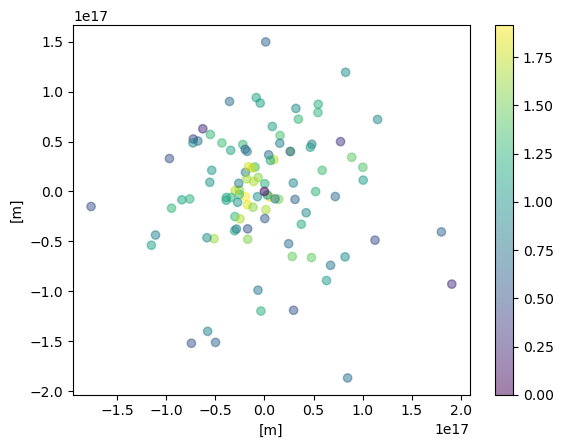

In [6]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x, bodies.y, c=v.value_in(units.kms), alpha=0.5)
    pyplot.colorbar()
    pyplot.show()
plot_snapshot(bodies)

cluster at Time= 0.0 Myr Mass= 4155945.22015 MSun Rvir= 1948.18186344 parsec
Number of binaries found: 138
first binary:                  key     hardness         mass         name  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg         none  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
12175864544613415701    4.374e+06    3.871e+31                -3.114e+09    0.000e+00    1.732e+12   -1.047e+02    3.107e+02    3.723e+02   -1.765e+17   -1.508e+16   -3.331e+15
10885465099380960815    4.374e+06    2.102e+31                -2.378e+09    0.000e+00    1.732e+12   -2.574e+02    1.149e+01    6.452e+01    1.908e+17   -9.286e+16 

cluster at Time= 0.0008 Myr Mass= 4155945.22015 MSun Rvir= 1735.13751724 parsec
Number of binaries found: 98
first binary:                  key     hardness         mass         name  potential_in_code       radius     timestep           vx           vy           vz            x            y            z
                   -         none           kg         none  m**2 * s**-2            m            s    m * s**-1    m * s**-1    m * s**-1            m            m            m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
12175864544613415701    2.543e+03    3.871e+31                -3.114e+09    0.000e+00    1.691e+09    3.395e+02    3.486e+02    3.807e+02   -1.765e+17   -1.507e+16   -3.321e+15
10885465099380960815    2.543e+03    2.102e+31                -2.378e+09    0.000e+00    1.691e+09   -4.713e+02    1.156e+02    1.697e+02    1.908e+17   -9.286e+1

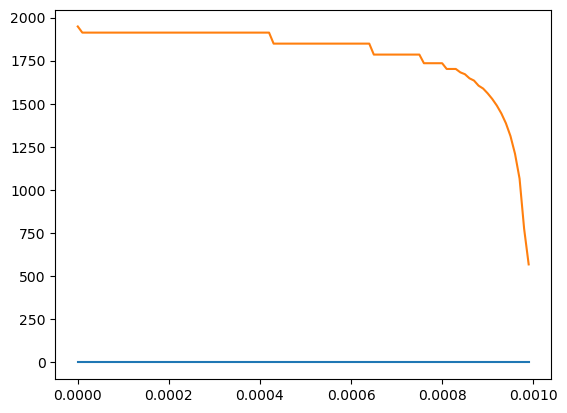

In [7]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = ph4(converter)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)


times = numpy.arange(0, 1, 0.01) | units.kyr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.yr)%100.0:
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
        b = bodies.get_binaries()
        if(len(b)>0):
            print("Number of binaries found:", len(b))
            print("first binary:", b[0])

pyplot.plot(times.value_in(units.Myr), RL25.value_in(units.parsec))
pyplot.plot(times.value_in(units.Myr), Rvir.value_in(units.parsec))
pyplot.show()

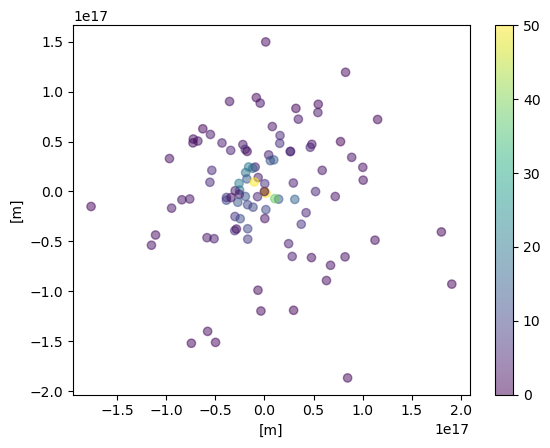

In [25]:
v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
scatter(bodies.x, bodies.y, c=v.value_in(units.kms), vmin=0, vmax=50, alpha=0.5)
pyplot.colorbar()
pyplot.show()